# MECANISMO BIELA-MANIVELA

## PROBLEMAS VELOCIDAD Y ACELERACIÓN

### PASO 1: MATRIZ JACOBIANA 

Para resolver el problema velocidad, necesitamos otra vez la matriz jacobiana. El método de construcción aparece detallado en el notebook Problema_Posición_4B, por lo que para este caso copiaremos el código de los pasos realizados para poder conseguirla.

In [1]:
import numpy as np
import math as math
import array as arr
import pprint  # para depurar
import matplotlib.pyplot as plt  #Para graficas
import matplotlib.animation as animation
import scipy.integrate as integrate 
import os
from time import sleep
#%matplotlib inline (Para notebook)



print ('BIELA-MANIVELA')
print ('=============================')
# Lectura de datos por teclado

meca = {} # dictionary vacio, con propiedades de mecanismo

meca["L1"] = float (input ('Introduce longitud L1:'))
meca["L2"] = float (input ('Introduce longitud L2:'))
meca["theta"] = float (input ('Introduce angulo inicial theta:')) #En rad
meca["XB"] = float (input ('Introduce coordenada en x del punto B:'))
meca["XC"] = float (input ('Introduce coordenada en x del punto C:'))
meca["XA"] = 0
meca["YA"] = 0
meca["YB"] = float (input ('Introduce coordenada en y del punto B:'))
meca["YC"] = float (input ('Introduce coordenada en y del punto c: '))

# Defino posicion inicial:
q = np.array ([[0.1], [0.2], [1], [0.2], [meca["theta"]]])
print('q: ' + str(q))

# JACOBIANO
def jacob_Phiq(q,meca):
    #Inicializa a cero la matriz jacobiana
    Jacob = np.zeros((5,5))

    #Extraer coordenadas

    X1 = q[0]
    Y1 = q[1]
    X2 = q[2]
    Y2 = q[3]
    theta = q[4]

    #Montar matriz

    Jacob[0,0] = 2*X1
    Jacob[0,1] = 2*Y1
    Jacob[1,0] = -2*(X2-X1)
    Jacob[1,1] = -2*(Y2-Y1)
    Jacob[1,2] = 2*(X2-X1)
    Jacob[1,3] = 2*(Y2-Y1)
    Jacob[2,2] = meca["YB"] - meca["YC"]
    Jacob[2,3] = meca["XC"] - meca["XB"]

    if (abs(math.cos(theta)) < (math.sqrt(2)/2) ):
        Jacob[3,4] = -meca["L1"]*math.sin(theta)
        Jacob[3,0] = 1
    else:
        Jacob[3,4] = meca["L1"]*math.cos(theta)
        Jacob[3,1] = 1

 
    Jacob[4,4] = 1

    return Jacob


def Phi (q,meca):
    #Inicializa a cero Phi
    Phi = np.zeros((5,1))

    #Extraer coordenadas
    X1 = q[0]
    Y1 = q[1]
    X2 = q[2]
    Y2 = q[3]
    theta = q[4]

    Phi[0] = X1**2 + Y1**2 - meca["L1"]**2
    Phi[1] = (X2-X1)**2 + (Y2-Y1)**2 -meca["L2"]**2
    Phi[2] = (meca["XC"] - meca["XB"])*(Y2-meca["YB"]) - (meca["YC"]-meca["YB"])*(X2-meca["XB"])


    if (abs(math.cos(theta)) < (math.sqrt(2)/2) ):
        Phi[3] = X1-meca["L1"]*math.cos(theta)
    else: 
        Phi[3] = Y1-meca["L1"]*math.sin(theta)
    
    
    
    return Phi



def resuelve_prob_posicion(q_init, meca):
    #Inicializacion de variables
    error = 1e10
    tolerancia = 1e-10

    #Inicializacion en cero de deltaQ, fi y q
    deltaQ = np.zeros ((5,1))
    q = q_init
    i=0

    # Iteraciones hasta conseguir que el error sea menor que la tolerancia

    while (error > tolerancia and i<=100):
        #print("q=")
        #pprint.pprint(q)


        #Extraer las coordenadas
        X1 = q[0]
        Y1 = q[1]
        X2 = q[2]
        Y2 = q[3]
        theta = q[4]
       
        fi=Phi(q,meca)
      
        J = jacob_Phiq(q,meca)

        
        deltaQ = np.linalg.solve(J,-fi)
        q = q + deltaQ
        error = np.linalg.norm(deltaQ)  # El error es el modulo del vector
        i=i+1
        
    if (error > tolerancia):
        raise Exception ('No se puede alcanzar la posición')
        
    return q

q = resuelve_prob_posicion(q,meca)


BIELA-MANIVELA
Introduce longitud L1:1
Introduce longitud L2:2
Introduce angulo inicial theta:0.5
Introduce coordenada en x del punto B:2
Introduce coordenada en x del punto C:3
Introduce coordenada en y del punto B:0
Introduce coordenada en y del punto c: 0
q: [[0.1]
 [0.2]
 [1. ]
 [0.2]
 [0.5]]


### PASO 2: PROBLEMA VELOCIDAD

Consiste en determinar las velocidades de todas las variables del mecanismo una vez sabemos su posición $q$ y la velocidad de los grados de libertad. 

Partimos de la ecuación:

$\Phi_q  =0 $

Derivando se obtiene:

$\Phi_q \dot{q} + \Phi_t = 0$

Siendo $\dot{q}$ el vector velocidad, $\Phi_q$ el jacobiano y $\Phi_t$ la derivada parcial de las ecuaciones de restricción respecto al tiempo. Para las ecuaciones de sólido rígido el valor de esta derivada es $0$. Solo tendría un valor no nulo la correspondiente al ángulo, que en ese caso tendría la velocidad que nosotros le indiquemos. 

De este modo la expresión quedaría:

$\Phi_q \dot{q} = -\Phi_t$

Este sistema de ecuaciones tiene infinitas soluciones y por tanto hay que ampliar añadiendo un dato conocido de velocidad, lo que se hace añadiendo una fila a la matriz de coeficientes del lado izquierdo y un dato a la columna del lado derecho de la ecuación por cada grado de libertad.

De esta forma llegamos a un sistema de ecuaciones lineal matricial de la forma:

$\mathbf{A} \mathbf{x} = \mathbf{b}$

Habría que multiplicar en ambas partes de la igualdad por la $A$ invertida en el lado izquierdo, del mismo modo que se hizo en el problema de posición. De esta manera quedaría:



$x = -A^{-1} b$

In [2]:
#PASO 2

def resuelve_prob_velocidad(q,qp,meca):
    qp = np.linalg.solve(jacob_Phiq(q,meca),qp)
    #print ("qp=")
    #pprint.pprint(qp)
 
    return qp

qp = np.zeros ((5,1))
#Velocidad del gdl. En una vuelta completa del angulo se cumple angulo=2*Pi*t
qp[4]=1

resuelve_prob_velocidad (q,qp, meca)

array([[ 0.47942554],
       [-0.87758256],
       [ 0.696111  ],
       [ 0.        ],
       [ 1.        ]])

### PASO 3: PROBLEMA ACELERACIÓN

El problema aceleración trata de determinar las aceleraciones de todas las variables del mecanismo, conociendo la posición$q$, la velocidad $\dot{q}$ y las aceleraciones de los grados de libertad. 

Partimos la ecuación que se obtiene tras derivar la ecuación inicial para el problema de velocidad, es decir:

$\Phi_q \dot{q} + \Phi_t = 0$

Se deriva por segunda vez:

$\dot{\Phi}_q \dot{q} + \Phi_q \ddot{q} + \dot{\Phi}_t = 0$

Despejamos $\Phi_q \ddot{q}$:

$\Phi_q \ddot{q} = -\dot{\Phi}_t - \dot{\Phi}_q  \dot{q}$


Siendo $\Phi_q$ el jacobiano, $\ddot{q}$ el vector aceleración, $\dot{q}$ el vector velocidad, $\dot{\Phi}_q$ la derivada del jacobiano respecto al tiempo y $\dot{\Phi}_t$ es la derivada de las ecuaciones de restricción con respecto al tiempo, cuyo valor es nulo. Es decir, tendríamos:

$\Phi_q \ddot{q} = - \dot{\Phi}_q  \dot{q}$

Del mismo modo que en el problema velocidad, llamando $b$ al conjunto formado por $\dot{\Phi}_q  \dot{q}$  llegamos a un sistema de ecuaciones lineal matricial:

$ \mathbf{A} \mathbf{x} = \mathbf{b}$

Y despejando la $x$:

$\mathbf{x} = \mathbf{A}^{-1} \mathbf{b}$


El vector velocidad será:

\begin{equation}
\mathbf{q_p} = 
\begin{bmatrix}
\dot{X}_1 \\
\dot{Y}_1 \\
\dot{X}_2 \\
\dot{Y}_2 \\
\dot{\theta}\\
\end{bmatrix}
\end{equation}

Por otro lado, para calcular la derivada del jacobiano solo tenemos en cuenta las filas que hacen referencia a las ecuaciones de las coordenadas independientes, ya que la última que añadimos para poder realizar los cálculos era adicional. Teniendo en cuenta esto, la derivada del jacobiano sería:

1. $Si ~~ \cos (θ) < \frac{1}{\sqrt{2}}$

\begin{equation}
\mathbf{\dot{\Phi}_q} = 
\begin{bmatrix}
2\dot{X}_1 & 2\dot{Y}_1 & 0 & 0 & 0  \\
-2(\dot{X}_2-\dot{X}_1) & -2(\dot{Y}_2-\dot{Y}_1) & 2(\dot{X}_2-\dot{X}_1) & 2(\dot{Y}_2-\dot{Y}_1) & 0\\
0 & 0 & \dot{Y}_C-\dot{Y}_B & \dot{X}_B-\dot{X}_C & 0  \\
1 & 0 & 0 & 0 & \dot{\theta}L_1\cos(\theta)\
\end{bmatrix}
\end{equation}


2. $Si ~~ \cos (θ) > \frac{1}{\sqrt{2}}$

\begin{equation}
\mathbf{\dot{\Phi}_q} = 
\begin{bmatrix}
2\dot{X}_1 & 2\dot{Y}_1 & 0 & 0 & 0  \\
-2(\dot{X}_2-\dot{X}_1) & -2(\dot{Y}_2-\dot{Y}_1) & 2(\dot{X}_2-\dot{X}_1) & 2(\dot{Y}_2-\dot{Y}_1) & 0\\
0 & 0 & \dot{Y}_C-\dot{Y}_B & \dot{X}_B-\dot{X}_C & 0  \\
0 & 1 & 0 & 0 & \dot{\theta}L_1\sin(theta)\\
\end{bmatrix}
\end{equation}



Como ya tenemos $\dot{\Phi}_q$ y $\dot{q}$, podemos calcular $b$. La última fila que añadimos es el valor de la aceleración angular, dato que sabemos de antemano. 


1. $Si ~~ \cos (\theta) < \frac{1}{\sqrt{2}}$

\begin{equation}
\mathbf{b} = 
\begin{bmatrix}
2\dot{X}_1^2 + 2\dot{Y}_1^2 \\
-2\dot{X}_1(\dot{X}_2-\dot{X}_1) & -2\dot{Y}_1(\dot{Y}_2-\dot{Y}_1) & 2\dot{X}_2(\dot{X}_2-\dot{X}_1) & 2\dot{Y}_2(\dot{Y}_2-\dot{Y}_1) & 0\\
2\dot{X}_2^2 + 2\dot{Y}_2^2  \\
\dot{\theta}^2L_1\cos(\theta)\\
1\\
\end{bmatrix}
\end{equation}

2. $Si ~~ \cos (\theta) > \frac{1}{\sqrt{2}}$

\begin{equation}
\mathbf{b} = 
\begin{bmatrix}
2\dot{X}_1^2 + 2\dot{Y}_1^2 \\
-2\dot{X}_1(\dot{X}_2-\dot{X}_1) & -2\dot{Y}_1(\dot{Y}_2-\dot{Y}_1) & 2\dot{X}_2(\dot{X}_2-\dot{X}_1) & 2\dot{Y}_2(\dot{Y}_2-\dot{Y}_1) & 0\\
2\dot{X}_2^2 + 2\dot{Y}_2^2  \\
\dot{\theta}^2L_1\sin(\theta)\\
1\\
\end{bmatrix}
\end{equation}

In [3]:
#PASO 3

def resuelve_prob_aceleracion (q,qp, qpp, meca):
    
    #Extraer las posiciones
    X1 = q[0]
    Y1 = q[1]
    X2 = q[2]
    Y2 = q[3]
    theta = q[4]
    #Extraer las velocidades
    X1q = qp[0]
    Y1q = qp[1]
    X2q = qp[2]
    Y2q = qp[3]
    thetaq = qp[4]
    b=qpp
    
    b[0] = 2*(X1q)**2 + 2*(Y1q)**2
    b[1] = -2*X1q*(X2q-X1q) - 2*Y1q*(Y2q-Y1q) + 2*X2q*(X2q-X1q) + 2*Y2q*(Y2q-Y1q)
    if (abs(math.cos(theta)) < (math.sqrt(2)/2) ):
        b[3] = thetaq**2 * (meca["L1"] * math.cos(theta))
    else: 
        b[3] =  thetaq**2 * (meca["L1"] * math.sin(theta))
    
    b[4] = 1 #Aceleracion conocida 
    qpp = np.linalg.solve(-jacob_Phiq(q,meca),b)

     
    return qpp


qpp=np.zeros((5,1))
qpp=resuelve_prob_aceleracion(q,qp,qpp,meca)
qpp

array([[-0.21751417],
       [ 0.39815702],
       [-0.31582383],
       [-0.        ],
       [-1.        ]])

### PASO 4: GRÁFICAS DE VELOCIDADES

Vamos a representar por separado la gráfica de la velocidad en cada coordenada $(X_1, ~ Y_1, ~ X_2 ~ e ~ Y_2)$.


VX1=
array([-0.00000000e+00,  1.27877459e-01,  2.53655164e-01,  3.75267839e-01,
        4.90718597e-01,  5.98111732e-01,  6.95683843e-01,  7.81832791e-01,
        8.55144007e-01,  9.14413715e-01,  9.58668706e-01,  9.87182310e-01,
        9.99486332e-01,  9.95378739e-01,  9.74926978e-01,  9.38466869e-01,
        8.86597087e-01,  8.20169338e-01,  7.40274368e-01,  6.48224057e-01,
        5.45529875e-01,  4.33878066e-01,  3.15101957e-01,  1.91151859e-01,
        6.40630383e-02, -6.40777009e-02, -1.91166281e-01, -3.15115902e-01,
       -4.33891304e-01, -5.45542189e-01, -6.48235245e-01, -7.40284246e-01,
       -8.20177744e-01, -8.86603883e-01, -9.38471943e-01, -9.74930247e-01,
       -9.95380149e-01, -9.99485861e-01, -9.87179965e-01, -9.58664526e-01,
       -9.14407768e-01, -8.55136390e-01, -7.81823630e-01, -6.95673288e-01,
       -5.98099957e-01, -4.90705795e-01, -3.75254220e-01, -2.53640952e-01,
       -1.27862887e-01,  1.46928204e-05])


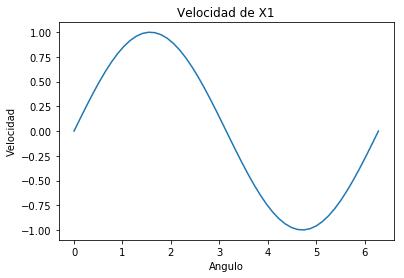

In [4]:
#PASO 4: VELOCIDAD DE X1
def grafica_velocidad(q,meca):
    
    th = np.linspace(0,2*3.1416,50)
    #print ("th=")
    #pprint.pprint(th)
    VX1 = np.zeros((50,0))
    VY1 = np.zeros((50,0))
    VX2 = np.zeros((50,0))
    VY2 = np.zeros((50,0))
    i=0
    for t in th:

        q[4] = t
        
        q = resuelve_prob_posicion (q, meca)
        qp = np.zeros ((5,1))
        #Velocidad del gdl. En una vuelta completa del angulo se cumple angulo=2*Pi*t
        qp[4]=1
        qp = resuelve_prob_velocidad (q,qp, meca)


        VX1 = np.append(VX1, qp[0])
        VY1 = np.append(VY1, qp[1])
        VX2 = np.append(VX2, qp[2])
        VY2 = np.append(VY1, qp[3])
        i=i+1
      
    print ("VX1=")
    pprint.pprint(VX1)
 
    plt.plot(th,VX1)
    plt.xlabel ('Angulo')
    plt.ylabel ('Velocidad')
    plt.title ('Velocidad de X1')

    plt.show()
    return 

grafica_velocidad (q,meca)

VY1=
array([-1.        , -0.99178998, -0.96729471, -0.92691642, -0.87131812,
       -0.80141273, -0.7183481 , -0.62348816, -0.51839052, -0.40478088,
       -0.28452471, -0.15959664, -0.03204798,  0.09602691,  0.22252503,
        0.34536928,  0.46254254,  0.57212084,  0.67230489,  0.76144965,
        0.83809138,  0.9009716 ,  0.94905783,  0.98156048,  0.99794585,
        0.99794491,  0.98155767,  0.9490532 ,  0.90096523,  0.83808336,
        0.76144013,  0.67229401,  0.57210879,  0.46252952,  0.34535549,
        0.2225107 ,  0.09601228, -0.03206267, -0.15961114, -0.2845388 ,
       -0.40479431, -0.51840308, -0.62349965, -0.71835832, -0.80142151,
       -0.87132533, -0.92692193, -0.96729844, -0.99179185, -1.        ])


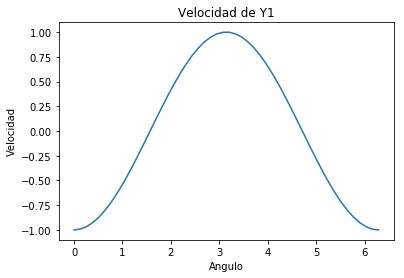

In [7]:
#PASO 4: VELOCIDAD DE Y1
def grafica_velocidad(q,meca):
    
    th = np.linspace(0,2*3.1416,50)
    #print ("th=")
    #pprint.pprint(th)

    VY1 = np.zeros((50,0))

    
    i=0
    for t in th:

        q[4] = t
        
        q=resuelve_prob_posicion (q,meca)
        qp = np.zeros((5,1))

        qp[4] = 1  #inicializar qp en 0 con qp[4] = 1 rad/s

        qp = resuelve_prob_velocidad(q,qp, meca)


        VY1 = np.append(VY1, qp[1])

        i=i+1
      
    print ("VY1=")
    pprint.pprint(VY1)
 
    plt.plot(th,VY1)
    plt.xlabel ('Angulo')
    plt.ylabel ('Velocidad')
    plt.title ('Velocidad de Y1')

    plt.show()
    return 

grafica_velocidad (q,meca)

VX2=
array([ 0.00000000e+00,  1.91421272e-01,  3.77333544e-01,  5.52333660e-01,
        7.11245622e-01,  8.49273159e-01,  9.62198408e-01,  1.04663593e+00,
        1.10033633e+00,  1.12250550e+00,  1.11406688e+00,  1.07776070e+00,
        1.01797657e+00,  9.40278403e-01,  8.50694430e-01,  7.54950220e-01,
        6.57848340e-01,  5.62926161e-01,  4.72404433e-01,  3.87346561e-01,
        3.07917854e-01,  2.33653849e-01,  1.63685911e-01,  9.69068642e-02,
        3.20809052e-02, -3.20882705e-02, -9.69143797e-02, -1.63693723e-01,
       -2.33662093e-01, -3.07926645e-01, -3.87355981e-01, -4.72414503e-01,
       -5.62936816e-01, -6.57859396e-01, -7.54961349e-01, -8.50705150e-01,
       -9.40288102e-01, -1.01798456e+00, -1.07776630e+00, -1.11406951e+00,
       -1.12250475e+00, -1.10033198e+00, -1.04662799e+00, -9.62187046e-01,
       -8.49258708e-01, -7.11228523e-01, -5.52314434e-01, -3.77312765e-01,
       -1.91399549e-01,  2.20392306e-05])


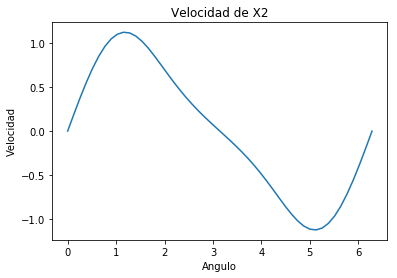

In [8]:
#PASO 4: VELOCIDAD DE X2
def grafica_velocidad(q,meca):
    
    th = np.linspace(0,2*3.1416,50)
    #print ("th=")
    #pprint.pprint(th)

    VX2 = np.zeros((50,0))

    
    i=0
    for t in th:

        q[4] = t
        
        q = resuelve_prob_posicion (q,meca)
        qp = np.zeros((5,1))

        qp[4] = 1  #inicializar qp en 0 con qp[4] = 1 rad/s

        qp = resuelve_prob_velocidad(q,qp,meca)


        VX2 = np.append(VX2, qp[2])

        i=i+1
      
    print ("VX2=")
    pprint.pprint(VX2)
 
    plt.plot(th,VX2)
    plt.xlabel ('Angulo')
    plt.ylabel ('Velocidad')
    plt.title ('Velocidad de X2')

    plt.show()
    return 

grafica_velocidad (q,meca)

VY2=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


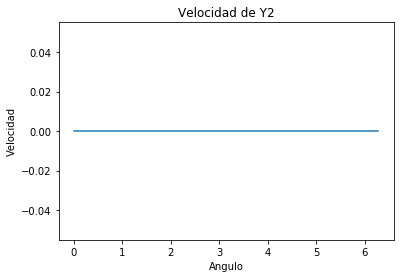

In [9]:
#PASO 4: VELOCIDAD DE Y2
def grafica_velocidad(q,meca):
    
    th = np.linspace(0,2*3.1416,50)
    #print ("th=")
    #pprint.pprint(th)

    VY2 = np.zeros((50,0))

    
    i=0
    for t in th:

        q[4] = t
        
        q = resuelve_prob_posicion (q,meca)
        qp = np.zeros((5,1))

        qp[4] = 1  #inicializar qp en 0 con qp[4] = 1 rad/s

        qp = resuelve_prob_velocidad(q,qp, meca)


        VY2 = np.append(VY2, qp[3])

        i=i+1
      
    print ("VY2=")
    pprint.pprint(VY2)
 
    plt.plot(th,VY2)
    plt.xlabel ('Angulo')
    plt.ylabel ('Velocidad')
    plt.title ('Velocidad de Y2')

    plt.show()
    return 

grafica_velocidad (q,meca)

### PASO 5: GRÁFICAS ACELERACIONES

Haremos el mismo procedimiento que para la velocidad, representando en celdas separadas la aceleración de cada coordenada.

AX1=
array([-1.        , -1.11966743, -1.22094987, -1.30218426, -1.36203671,
       -1.39952446, -1.41403194, -1.40532095, -1.37353452, -1.31919459,
       -1.24319342, -1.14677895, -1.03153431, -0.89935183, -0.75240195,
       -0.59309759, -0.42405454, -0.2480485 , -0.06796948,  0.11322559,
        0.2925615 ,  0.46709353,  0.63395587,  0.79040862,  0.93388282,
        1.06202261,  1.17272395,  1.2641691 ,  1.33485653,  1.38362555,
        1.40967537,  1.41257826,  1.39228653,  1.3491334 ,  1.28382743,
        1.19744095,  1.09139243,  0.96742319,  0.82756882,  0.67412573,
        0.50961346,  0.33673331,  0.15832398, -0.02268503, -0.20332156,
       -0.38061953, -0.55166771, -0.71365749, -0.86392897, -1.00001469])


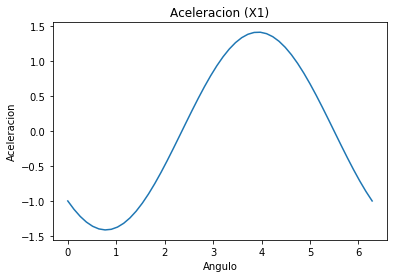

In [14]:
#PASO 5: ACELERACION DE X1

def grafica_aceleracion(q,meca):
    
    th = np.linspace(0,2*3.1416,50)
 
    
    AX1 = np.zeros((50,0))

    i=0
    for t in th:

        
        q[4] = t
        q = resuelve_prob_posicion (q,meca)
        
        qp = np.zeros((5,1))
        qp[4] = 1  #inicializar qp en 0 con qp[4] = 1 rad/s
        qp = resuelve_prob_velocidad(q, qp, meca)
        
        qpp = np.zeros((5,1))
        qpp[4] = 1  #inicializar qp en 0 con qpp[4] = 1 rad/s**2
        qpp = resuelve_prob_aceleracion(q,qp, qpp, meca)
        
        
        AX1 = np.append(AX1, qpp[0])

        i=i+1
      
    print ("AX1=")
    pprint.pprint(AX1)	
 
    plt.plot(th,AX1)
    plt.xlabel ('Angulo')
    plt.ylabel ('Aceleracion')
    plt.title ('Aceleracion (X1)')	

    plt.show()
    return 

grafica_aceleracion (q,meca)


AY1=
array([ 1.        ,  0.86391252,  0.71363955,  0.55164858,  0.38059952,
        0.20330099,  0.02266426, -0.15834463, -0.33675349, -0.50963284,
       -0.67414399, -0.82758567, -0.96743835, -1.09140564, -1.197452  ,
       -1.28383614, -1.34913963, -1.39229018, -1.41257925, -1.40967371,
       -1.38362125, -1.33484967, -1.26415978, -1.17271233, -1.06200889,
       -0.93386721, -0.79039139, -0.63393729, -0.46707392, -0.29254117,
       -0.11320488,  0.06799024,  0.24806895,  0.42407437,  0.59311646,
        0.75241955,  0.89936787,  1.03154853,  1.14679111,  1.24320332,
        1.31920208,  1.37353947,  1.40532328,  1.41403161,  1.39952147,
        1.36203112,  1.30217615,  1.22093939,  1.11965474,  0.99998531])


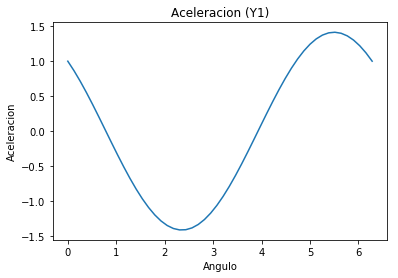

In [15]:
#PASO 5: ACELERACION DE Y1

def grafica_aceleracion(q,meca):
    
    th = np.linspace(0,2*3.1416,50)
 
    
    AY1 = np.zeros((50,0))

    i=0
    for t in th:

        q[4] = t
        q = resuelve_prob_posicion (q,meca)
        
        qp = np.zeros((5,1))
        qp[4] = 1  #inicializar qp en 0 con qp[4] = 1 rad/s
        qp = resuelve_prob_velocidad(q, qp, meca)
        
        qpp = np.zeros((5,1))
        qpp[4] = 1  #inicializar qp en 0 con qpp[4] = 1 rad/s**2
        qpp = resuelve_prob_aceleracion(q,qp, qpp, meca)
        
        
        AY1 = np.append(AY1, qpp[1])

        i=i+1
      
    print ("AY1=")
    pprint.pprint(AY1)	
 
    plt.plot(th,AY1)
    plt.xlabel ('Angulo')
    plt.ylabel ('Aceleracion')
    plt.title ('Aceleracion (Y1)')	

    plt.show()
    return 

grafica_aceleracion (q,meca)

AX2=
array([-1.5       , -1.66987331, -1.79154443, -1.86087837, -1.87501466,
       -1.83282475, -1.73551832, -1.58733401, -1.396143  , -1.17365994,
       -0.93487648, -0.6964468 , -0.4741562 , -0.28016803, -0.12107542,
        0.00248058,  0.09463054,  0.16224671,  0.21295674,  0.25377343,
        0.29045674,  0.32742865,  0.36798494,  0.41459975,  0.46920274,
        0.5333725 ,  0.60842274,  0.69536744,  0.79474845,  0.90630588,
        1.02848105,  1.15778062,  1.28811371,  1.41034032,  1.51239103,
        1.58031873,  1.60038788,  1.56178889,  1.45905914,  1.29323488,
        1.07132283,  0.80449701,  0.50590233,  0.1888416 , -0.13431537,
       -0.45255922, -0.75624468, -1.03690789, -1.28705742, -1.50002204])


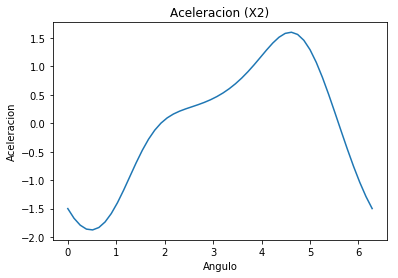

In [16]:
#PASO 5: ACELERACION DE X2

def grafica_aceleracion(q,meca):
    
    th = np.linspace(0,2*3.1416,50)
 
    
    AX2 = np.zeros((50,0))

    i=0
    for t in th:

        
        q[4] = t
        q = resuelve_prob_posicion (q,meca)
        
        qp = np.zeros((5,1))
        qp[4] = 1  #inicializar qp en 0 con qp[4] = 1 rad/s
        qp = resuelve_prob_velocidad(q, qp, meca)
        
        qpp = np.zeros((5,1))
        qpp[4] = 1  #inicializar qp en 0 con qpp[4] = 1 rad/s**2
        qpp = resuelve_prob_aceleracion(q,qp, qpp, meca)
        
        
        AX2 = np.append(AX2, qpp[2])

        i=i+1
      
    print ("AX2=")
    pprint.pprint(AX2)	
 
    plt.plot(th,AX2)
    plt.xlabel ('Angulo')
    plt.ylabel ('Aceleracion')
    plt.title ('Aceleracion (X2)')	

    plt.show()
    return 

grafica_aceleracion (q,meca)

AY2=
array([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.])


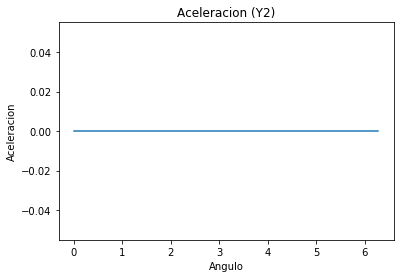

In [17]:
#PASO 5: ACELERACION DE Y2

def grafica_aceleracion(q,meca):
    
    th = np.linspace(0,2*3.1416,50)
 
    
    AY2 = np.zeros((50,0))

    i=0
    for t in th:

        q[4] = t
        q = resuelve_prob_posicion (q,meca)
        
        qp = np.zeros((5,1))
        qp[4] = 1  #inicializar qp en 0 con qp[4] = 1 rad/s
        qp = resuelve_prob_velocidad(q, qp, meca)
        
        qpp = np.zeros((5,1))
        qpp[4] = 1  #inicializar qp en 0 con qpp[4] = 1 rad/s**2
        qpp = resuelve_prob_aceleracion(q,qp, qpp, meca)
        
        AY2 = np.append(AY2, qpp[3])

        i=i+1
      
    print ("AY2=")
    pprint.pprint(AY2)	
 
    plt.plot(th,AY2)
    plt.xlabel ('Angulo')
    plt.ylabel ('Aceleracion')
    plt.title ('Aceleracion (Y2)')	

    plt.show()
    return 

grafica_aceleracion (q,meca)